In [4]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import html5lib
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

In [5]:
## Proxy settings when using cntlm
http_proxy  = "http://localhost:3128"
https_proxy = "https://localhost:3128"

proxyDict = { 
              "http"  : http_proxy, 
              "https" : https_proxy, 
            }
proxyDict = None

In [6]:
from typing import Callable, List
from pandas import DataFrame, Series

def nb_bootstrap_sample(data: Series, func: Callable[[Series], float]) -> float:
    """
    Generate a bootstrap sample from a pandas Series object.
    :arg data: a pandas Series object
    :arg func: a function (e.g. mean)
    :return: the generated bootstrap sample.
    """
    return func(np.random.choice(data, len(data)))

In [7]:
def scrape(url,table_num, proxy):
    r = requests.get(url, proxies=proxy)
    soup = BeautifulSoup(r.text, "html")
    table = soup.find_all('table')[table_num] ## Last 50 games
    data = []
    rows = table.find_all(['tr','th'])
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])
    winloss = data[9:]
    d = {}
    for i in range(len(winloss)):
        d[winloss[i][0]] = winloss[i][-1]
    return pd.DataFrame.from_dict(d, orient='index',columns=['WinLoss'])

## convert W,L's to binary for length 'past_games' 
## starting from 'start_position' taken from the end 
def win_loss_binary(df, team, past_games, start_position):
    wlstr = [c for c in (df[df.index == team].values)[0][0]]
    wl = []
    for c in wlstr:
        if c == 'W':
            wl.append(1)
        else:
            wl.append(0)
    l = len(wl)
    return wl[max(l-past_games-start_position,0) : l-start_position]

In [8]:
## Boostrap statistic
def bootstr_mean(df,team, past_games, simulations, start_position):
    """
    Bootstrap samples and takes mean for simulations number of times.
    """
    values = win_loss_binary(df, team, past_games, start_position)
    bootstrapped = []
    for i in range(simulations):
        generated = nb_bootstrap_sample(values, np.mean)
        bootstrapped.append(generated)
    return bootstrapped

In [10]:
mapping = {
    'Richmond': 'richmond',
    'West Coast': 'westcoast',
    'Sydney': 'swans',
    'Adelaide': 'adelaide',
    'Geelong': 'geelong',
    'Greater Western Sydney': 'gws',
    'Melbourne': 'melbourne',
    'Port Adelaide': 'padelaide',
    'Collingwood': 'collingwood',
    'Hawthorn': 'hawthorn',
    'Essendon': 'essendon',
    'Western Bulldogs': 'bullldogs',
    'St Kilda': 'stkilda',
    'North Melbourne': 'kangaroos',
    'Fremantle': 'fremantle',
    'Brisbane Lions': 'brisbanel',
    'Gold Coast': 'goldcoast',
    'Carlton': 'carlton'
}
url = 'https://afltables.com/afl/teams/allteams/last20.html'
win_loss_df = scrape(url,2,proxyDict) #table 2 is last 50 games
win_loss_df.index

Index(['Richmond', 'West Coast', 'Geelong', 'Greater Western Sydney',
       'Adelaide', 'Port Adelaide', 'Sydney', 'Melbourne', 'Collingwood',
       'Brisbane Bears', 'Hawthorn', 'Essendon', 'Western Bulldogs',
       'St Kilda', 'North Melbourne', 'Fremantle', 'Brisbane Lions',
       'Gold Coast', 'Carlton', 'Fitzroy', 'University'],
      dtype='object')

In [11]:
win_loss_df.head()

,WinLoss
Richmond,WWWWLLLLWWLWWLWWWWLWWWWWWLWWWWWWLWWLWWWLWWWWWW...
West Coast,WLWLWWWLLLWLWLWLWLWLWWLLWWWWWWWWWWLLLWWWLWWLWW...
Geelong,WWWWWLLLWWWLWDWWLWLWWWLWLWLLWWLWWLWWWLLWLWWLLW...
Greater Western Sydney,WWWWWLWWWWLWDDLLWWWWLLWLWWLWDWLLLLWWWWLWWWWWLL...
Adelaide,LWWWWWWLLWWLWLWWWWDWWLLWWLLWWLWWWLWLLLLWLWWLWL...


In [12]:
## Grounds
scrape('https://afltables.com/afl/teams/swans/last20.html',5,proxyDict).index

Index(['Yarraville Oval', 'York Park', 'Perth Stadium', 'Bellerive Oval',
       'Coburg Oval', 'Wellington', 'Albury', 'Adelaide Oval', 'Carrara',
       'S.C.G.', 'Lake Oval', 'Junction Oval', 'Sydney Showground',
       'Manuka Oval', 'All venues', 'Docklands', 'Gabba', 'Stadium Australia',
       'Glenferrie Oval', 'East Melbourne', 'Toorak Park', 'Football Park',
       'Punt Rd', 'M.C.G.', 'Arden St', 'Moorabbin Oval', 'Brunswick St',
       'Waverley Park', 'Subiaco', 'Kardinia Park', 'W.A.C.A.', 'Corio Oval',
       'Western Oval', 'Princes Park', 'Windy Hill', 'Victoria Park'],
      dtype='object')

In [23]:
def win_streak(team,rnd):
    """
    Calculate the winning streak of team
    """
    s = win_loss_df[win_loss_df.index == team].values[0][0]
    s = s[::-1]
    i = 0
    win_streak = 0
    while i < rnd:
        if s[i] == 'W':
            i += 1
            win_streak += 1
        else:
            return win_streak
    return win_streak

def loss_streak(team,rnd):
    """
    Calculate the losing streak of team
    """
    s = win_loss_df[win_loss_df.index == team].values[0][0]
    s = s[::-1]
    i = 0
    loss_streak = 0
    while i < rnd:
        if s[i] == 'L':
            i += 1
            loss_streak += 1
        else:
            return loss_streak
    return loss_streak

## Games

In [14]:
round1 = [['Carlton', 'Richmond', 'M.C.G.'],
          ['Collingwood', 'Geelong', 'M.C.G.'],
          ['Melbourne', 'Port Adelaide', 'M.C.G.'],
          [ 'Adelaide', 'Hawthorn', 'Adelaide Oval'],
          [ 'Western Bulldogs', 'Sydney', 'Docklands'],
          [ 'Brisbane Lions', 'West Coast', 'Gabba'],
          [ 'St Kilda', 'Gold Coast', 'Docklands'],
          [ 'Greater Western Sydney', 'Essendon','Sydney Showground'],
          [ 'Fremantle', 'North Melbourne', 'Perth Stadium']]
round1_results = [0,0,0,0,1,1,1,1,1]

round2 = [['Richmond', 'Collingwood', 'M.C.G.'],
          [ 'Sydney', 'Adelaide', 'S.C.G.'],
          [ 'Essendon', 'St Kilda', 'Docklands'],
          ['Port Adelaide', 'Carlton','Adelaide Oval'],
          [ 'Geelong', 'Melbourne', 'Kardinia Park'],
          [ 'West Coast', 'Greater Western Sydney', 'Perth Stadium'],
          [ 'North Melbourne', 'Brisbane Lions', 'Docklands'],
          [ 'Hawthorn', 'Western Bulldogs', 'M.C.G.'],
          [ 'Gold Coast', 'Fremantle', 'Carrara']]
round2_results = [0,0,0,1,1,1,0,0,1]

## Duplicate those games that could be home for wither team
round3 = [['Adelaide','Geelong', 'Adelaide Oval'],
          ['Melbourne', 'Essendon', 'M.C.G.'],
          ['Essendon', 'Melbourne', 'M.C.G.'],
          ['Carlton', 'Sydney', 'Docklands'],
          ['Greater Western Sydney', 'Richmond', 'Sydney Showground'],
          ['Brisbane Lions', 'Port Adelaide', 'Gabba'],
          ['Collingwood', 'West Coast', 'M.C.G.'],
          ['Western Bulldogs', 'Gold Coast', 'Docklands'],
          ['Hawthorn', 'North Melbourne', 'M.C.G.'],
          ['North Melbourne', 'Hawthorn', 'M.C.G.'],
          ['Fremantle', 'St Kilda', 'Perth Stadium']]
round3_results = []

## Model

In [25]:
## Up to round 2
games_so_far = len(round1_results+round2_results)

training = pd.concat([pd.read_csv('training/round1-2019.csv'),
                     pd.read_csv('training/round2-2019.csv')], axis=0, ignore_index=True)
training = training.iloc[:games_so_far,:]
training.head()

,h,a,grnd,h_wins_5p,h_wins_50p,h_wins_95p,a_wins_5p,a_wins_50p,a_wins_95p,h_grnd_5p,...,a_grnd_5p,a_grnd_50p,a_grnd_95p,h_vs_a_5p,h_vs_a_50p,h_vs_a_95p,h_w_streak,a_w_streak,h_l_streak,a_l_streak
0,Carlton,Richmond,M.C.G.,0.0,0.1,0.3,0.6,0.8,1.0,0.0,...,0.4,0.8,1.0,0.0,0.0,0.0,0,0,0,0
1,Collingwood,Geelong,M.C.G.,0.2,0.5,0.8,0.3,0.6,0.8,0.4,...,0.0,0.2,0.6,0.0,0.4,0.8,0,0,0,0
2,Melbourne,Port Adelaide,M.C.G.,0.3,0.6,0.8,0.2,0.4,0.7,0.3,...,0.2,0.6,1.0,0.0,0.4,0.8,0,0,0,0
3,Adelaide,Hawthorn,Adelaide Oval,0.3,0.6,0.8,0.5,0.7,0.9,0.3,...,0.4,0.8,1.0,0.0,0.2,0.6,0,0,0,0
4,Western Bulldogs,Sydney,Docklands,0.2,0.5,0.8,0.2,0.4,0.7,0.3,...,0.0,0.4,0.8,0.2,0.6,1.0,0,0,0,0


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

# Round 1 training data scaled
X1 = training.iloc[:9,3:].values
X1 = preprocessing.scale(X1)

# Round 2 training data scaled
X2 = training.iloc[9:,3:].values
X2 = preprocessing.scale(X2)

X = np.concatenate([X1,X2])
y = np.array(round1_results + round2_results)
estimator = LogisticRegression(penalty='l2',solver='lbfgs', C=2)

cv_results = cross_validate(estimator, X, y, cv=3, return_train_score=True)
print("K-fold CV on training", cv_results['train_score'])
print("K-fold CV on validation", cv_results['test_score'])

clf = estimator.fit(X,y)
print("Model accuracy on full training set")
print(clf.score(X,y))
print('Model scored on full training set')
pd.DataFrame(list(zip(clf.predict_proba(X)[:,1],y)),columns=['predicted','actual'])

K-fold CV on training [1.         0.91666667 0.91666667]
K-fold CV on validation [0.33333333 0.33333333 0.33333333]
Model accuracy on full training set
0.9444444444444444
Model scored on full training set


,predicted,actual
0,0.353967,0
1,0.447154,0
2,0.336028,0
3,0.189861,0
4,0.520982,1
5,0.333002,1
6,0.968351,1
7,0.644640,1
8,0.641084,1
9,0.336943,0


In [26]:
# The odds of features
pd.DataFrame(list(zip(training.iloc[:,3:].columns, np.exp(clf.coef_)[0])),columns=['column','odds'])

,column,odds
0,h_wins_5p,2.063647
1,h_wins_50p,0.731532
2,h_wins_95p,0.595782
3,a_wins_5p,2.957140
4,a_wins_50p,0.705690
5,a_wins_95p,0.339777
6,h_grnd_5p,1.301751
7,h_grnd_50p,0.723690
8,h_grnd_95p,0.662897
9,a_grnd_5p,0.573987


In [142]:
scores = pd.read_csv('afl_training/round3-2019.csv')
X = scores.iloc[:,3:].values
X = preprocessing.scale(X)
scores['scores'] = clf.predict_proba(X)[:,1]
scores[['h','a','grnd','scores']]

,h,a,grnd,scores
0,Adelaide,Geelong,Adelaide Oval,0.689880
1,Melbourne,Essendon,M.C.G.,0.215847
2,Essendon,Melbourne,M.C.G.,0.093041
3,Carlton,Sydney,Docklands,0.730797
4,Greater Western Sydney,Richmond,Sydney Showground,0.229106
5,Brisbane Lions,Port Adelaide,Gabba,0.562241
6,Collingwood,West Coast,M.C.G.,0.444416
7,Western Bulldogs,Gold Coast,Docklands,0.932313
8,Hawthorn,North Melbourne,M.C.G.,0.585663
9,North Melbourne,Hawthorn,M.C.G.,0.379100


## Generate training data

In [21]:
# Generating training records. Each element of records represent a row of the features
#               'h_wins_5p','h_wins_50p','h_wins_95p',
#               'a_wins_5p','a_wins_50p','a_wins_95p',
#               'h_grnd_5p','h_grnd_50p','h_grnd_95p',
#               'a_grnd_5p','a_grnd_50p','a_grnd_95p',
#               'h_vs_a_5p','h_vs_a_50p','h_vs_a_95p'

games = round3
start_position = 0 # Not really needed 
past_games = 10 # look back this many games
simulations = 10000 # simulations for bootstrapping

records = []
for r in games:
    team1, team2, ground = r

    t1 = bootstr_mean(win_loss_df, team1, past_games, simulations, start_position)
    t2 = bootstr_mean(win_loss_df, team2, past_games, simulations, start_position)

    t1_list = win_loss_df[win_loss_df.index == team1].values[0][0]
    t2_list = win_loss_df[win_loss_df.index == team2].values[0][0]
    print(team1,team2,'overall')
    print(t1_list[len(t1_list)-past_games-start_position:len(t1_list)-start_position])
    print(t2_list[len(t2_list)-past_games-start_position:len(t2_list)-start_position])

    team1_url = 'https://afltables.com/afl/teams/'+mapping[team1]+'/last20.html'
    team2_url = 'https://afltables.com/afl/teams/'+mapping[team2]+'/last20.html'
    vs_df = scrape(team1_url,2,proxyDict) #table 2 is last 50 games
    t1vt2 = bootstr_mean(vs_df, team2, 5, simulations, start_position)

    vs_list = vs_df[vs_df.index == team2].values[0][0]
    print(team1,'vs',team2)
    print(vs_list[max(len(vs_list)-past_games-start_position,0):len(vs_list)-start_position])

    t1_ground_df = scrape(team1_url,5,proxyDict)
    t2_ground_df = scrape(team2_url,5,proxyDict)
    t1_grnd = bootstr_mean(t1_ground_df, ground, 10, simulations, start_position) 
    ## Home team plays ~2 times more games at home
    t2_grnd = bootstr_mean(t2_ground_df, ground, 5, simulations, start_position)

    t1_list = t1_ground_df[t1_ground_df.index==ground].values[0][0]
    t2_list = t2_ground_df[t2_ground_df.index==ground].values[0][0]
    print(team1,team2,ground)
    print(t1_list[len(t1_list)-past_games-start_position:len(t1_list)-start_position])
    print(t2_list[len(t2_list)-past_games-start_position:len(t2_list)-start_position])
    
    dist_features = np.concatenate((np.percentile(t1, [5,50,95]),np.percentile(t2, [5,50,95])
                ,np.percentile(t1_grnd, [5,50,95]),np.percentile(t2_grnd, [5,50,95])
                ,np.percentile(t1vt2, [5,50,95])))
    x = dist_features.tolist()
    print(x)
    x = np.array(x)
    records.append(x)

Adelaide Geelong overall
LWWLWLWWLW
LWWLLWWLWW
Adelaide vs Geelong
LWLLLLLWWW
Adelaide Geelong Adelaide Oval
WLWLWWLWWL
WL
[0.3, 0.6, 0.8, 0.3, 0.6, 0.8, 0.3, 0.6, 0.8, 0.0, 0.4, 0.8, 0.2, 0.6, 1.0]
Melbourne Essendon overall
WWLWWWWLLL
LWWWLWLWLL
Melbourne vs Essendon
LWWWLWLLWW
Melbourne Essendon M.C.G.
WLLWWLWWWL
WWLLLWLLLL
[0.3, 0.6, 0.8, 0.2, 0.5, 0.8, 0.3, 0.6, 0.8, 0.0, 0.2, 0.6, 0.2, 0.6, 1.0]
Essendon Melbourne overall
LWWWLWLWLL
WWLWWWWLLL
Essendon vs Melbourne
WLLLWLWWLL
Essendon Melbourne M.C.G.
WWLLLWLLLL
WLLWWLWWWL
[0.2, 0.5, 0.8, 0.3, 0.6, 0.8, 0.1, 0.3, 0.5, 0.2, 0.6, 1.0, 0.0, 0.4, 0.8]
Carlton Sydney overall
LLLWLLLLLL
WLLWWWLLLL
Carlton vs Sydney
LLLLLLLWLL
Carlton Sydney Docklands
LWLLLLLLLL
WLWWWWLWLL
[0.0, 0.1, 0.3, 0.2, 0.4, 0.7, 0.0, 0.1, 0.3, 0.0, 0.4, 0.8, 0.0, 0.2, 0.6]
Greater Western Sydney Richmond overall
WWWWLLWLWL
WWWWWWWLWL
Greater Western Sydney vs Richmond
LLLLLWWLLW
Greater Western Sydney Richmond Sydney Showground
WWLLWWWWLW
WWWLL
[0.3, 0.6, 0.8, 0

In [22]:
#########################################################################################################
#### Write out training data set (include win and loss streaks as featuers)
#########################################################################################################
rnds_so_far = 2
rnd = round3

h_a_grnd = pd.DataFrame(rnd)
print(h_a_grnd)
df = pd.concat([h_a_grnd,pd.DataFrame(records)
                    ], axis=1)

df.columns = [
              'h','a','grnd',
              'h_wins_5p','h_wins_50p','h_wins_95p',
              'a_wins_5p','a_wins_50p','a_wins_95p',
              'h_grnd_5p','h_grnd_50p','h_grnd_95p',
              'a_grnd_5p','a_grnd_50p','a_grnd_95p',
              'h_vs_a_5p','h_vs_a_50p','h_vs_a_95p'
             ]
h_w_streak  = [win_streak(i[0],rnds_so_far) for i in rnd]
a_w_streak  = [win_streak(i[1],rnds_so_far) for i in rnd]
df['h_w_streak'] = h_w_streak 
df['a_w_streak'] = a_w_streak

h_l_streak  = [loss_streak(i[0],rnds_so_far) for i in rnd]
a_l_streak  = [loss_streak(i[1],rnds_so_far) for i in rnd]
df['h_l_streak'] = h_l_streak 
df['a_l_streak'] = a_l_streak
df
# df.to_csv('training/round3-2019.csv',index=False)

                         0                1                  2
0                 Adelaide          Geelong      Adelaide Oval
1                Melbourne         Essendon             M.C.G.
2                 Essendon        Melbourne             M.C.G.
3                  Carlton           Sydney          Docklands
4   Greater Western Sydney         Richmond  Sydney Showground
5           Brisbane Lions    Port Adelaide              Gabba
6              Collingwood       West Coast             M.C.G.
7         Western Bulldogs       Gold Coast          Docklands
8                 Hawthorn  North Melbourne             M.C.G.
9          North Melbourne         Hawthorn             M.C.G.
10               Fremantle         St Kilda      Perth Stadium


## Distributions

[0.5 0.7 0.9]
[0.2 0.4 0.7]


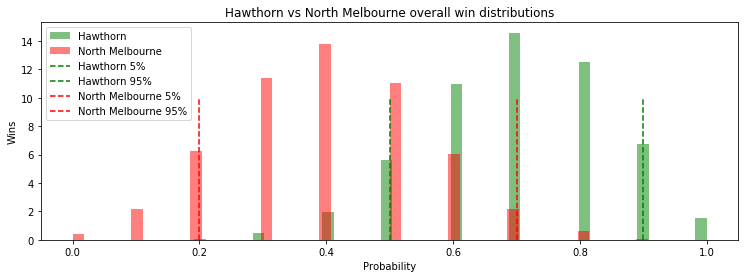

In [133]:
# In Generating Data cell, retrict games to a single element e.g. 'for r in games[2:3]' then run this cell. 

plt.figure(figsize=(12.5,4))
line_height = 10

x = plt.hist(t1, bins='auto', density=True, facecolor='green', label=team1, alpha=0.5)
y = plt.hist(t2, bins='auto', density=True, facecolor='red', label=team2, alpha=0.5)

plt.vlines(np.percentile(t1, 5), 0, line_height, linestyle="--", colors='green', label=team1+" 5%")
plt.vlines(np.percentile(t1, 95), 0, line_height, linestyle="--", colors='green', label=team1+" 95%")

plt.vlines(np.percentile(t2, 5), 0, line_height, linestyle="--", colors='red', label=team2+" 5%")
plt.vlines(np.percentile(t2, 95), 0, line_height, linestyle="--", colors='red', label=team2+" 95%")

plt.ylabel('Wins')
plt.xlabel('Probability')
plt.legend()
plt.title(team1+' vs '+team2+' overall win distributions')

print(np.percentile(t1, [5,50,95]))
print(np.percentile(t2, [5,50,95]))

Text(0.5, 1.0, 'Hawthorn vs North Melbourne')

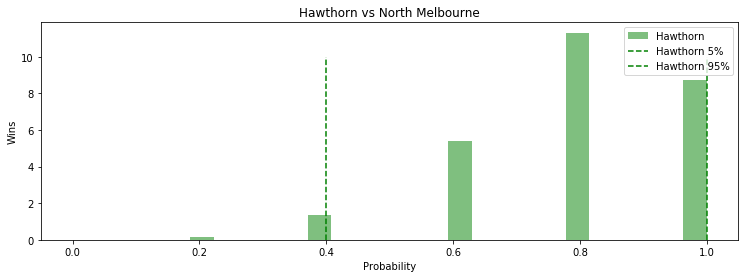

In [134]:
plt.figure(figsize=(12.5,4))
line_height = 10

plt.hist(t1vt2, bins='auto', density=True, facecolor='green', label=team1, alpha=0.5)

plt.vlines(np.percentile(t1vt2, 5), 0, line_height, linestyle="--", colors='green', label=team1+" 5%")
plt.vlines(np.percentile(t1vt2, 95), 0, line_height, linestyle="--", colors='green', label=team1+" 95%")

plt.ylabel('Wins')
plt.xlabel('Probability')
plt.legend()
plt.title(team1+' vs '+team2)

[0.2 0.5 0.8]
[0.  0.4 0.8]


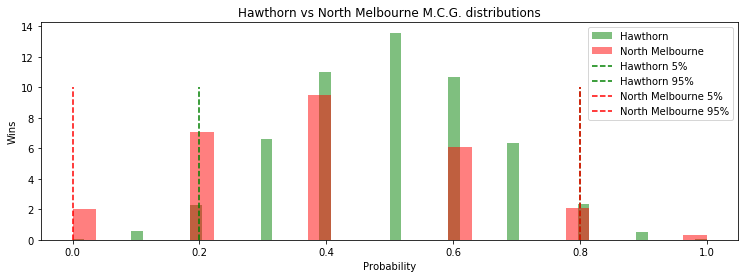

In [135]:
plt.figure(figsize=(12.5,4))
line_height = 10

x = plt.hist(t1_grnd, bins='auto', density=True, facecolor='green', label=team1, alpha=0.5)
y = plt.hist(t2_grnd, bins='auto', density=True, facecolor='red', label=team2, alpha=0.5)

plt.vlines(np.percentile(t1_grnd, 5), 0, line_height, linestyle="--", colors='green', label=team1+" 5%")
plt.vlines(np.percentile(t1_grnd, 95), 0, line_height, linestyle="--", colors='green', label=team1+" 95%")

plt.vlines(np.percentile(t2_grnd, 5), 0, line_height, linestyle="--", colors='red', label=team2+" 5%")
plt.vlines(np.percentile(t2_grnd, 95), 0, line_height, linestyle="--", colors='red', label=team2+" 95%")

plt.ylabel('Wins')
plt.xlabel('Probability')
plt.legend()
plt.title(team1+' vs '+team2+' '+ground+' distributions')
    
print(np.percentile(t1_grnd, [5,50,95]))
print(np.percentile(t2_grnd, [5,50,95]))